<a href="https://colab.research.google.com/github/harry-erskine/PRBX-Travel-Mode-Identification/blob/main/Source%20Code/Support%20Vector%20Machines/SVM_using_an_RBF_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Support Vector Machines**

### **Data Preferences**

In [ ]:
### VARIABLES ###

groupSize = 16                  # How many trajectories are represented in each group
motion_points = groupSize - 3    # Do not change this variable

# variables below all 'True' or 'False' (where all 'False' represents the most filtered version of the data)

include_impossible_groups = False      # include groups with trajectories that I have deemed to be invalid
include_stationary_groups = False      # include groups where there is less than 3 meters of total movement
include_airplane_and_boat = False      # include groups where the mode of transportation was 'airplane' or 'boat'
include_all_time_ranges = False        # include groups where the time between each trajectory is more than 1 second

### **Notebook Setup**

In [ ]:
### INSTALLS ###

# !pip install --upgrade gspread
# !pip install pandas
# !pip install scikit-learn

In [ ]:
### IMPORTS ###

import os
from google.colab import drive
import pandas as pd
import numpy as np
import time
#
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from mpl_toolkits import mplot3d
from sklearn.metrics import accuracy_score

In [ ]:
### MOUNT GOOGLE DRIVE ###

mainMountPath = '/content/gdrive'
mainDrivePath = '/content/gdrive/MyDrive/Colab Notebooks/PRBX'

drive.mount(mainMountPath, force_remount=True)

Mounted at /content/gdrive


In [ ]:
### FILE PATHS ###

generatedFilesPath = mainDrivePath + '/Data Files/Generated Files'
cleanedMotionDataPath = generatedFilesPath + '/cleanedMotionDataX' + str(groupSize) + '.csv'

In [ ]:
cmdf = pd.read_csv(cleanedMotionDataPath)
cmdf = cmdf.drop('Unnamed: 0', axis=1)

In [ ]:
df = cmdf

if include_impossible_groups == False:
  df = df[df['Impossible'] == False]

if include_stationary_groups == False:
  df = df[df['Stationary'] == False]

if include_airplane_and_boat == False:
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)
  df.drop(df[df['Mode'] == 'boat'].index, inplace=True)

if include_all_time_ranges == False:
  df = df[df['DT Max'] == 1]

df = df.reset_index(drop=True)
df

<ipython-input-7-26835d7f0274>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)


,GroupId,UserId,Mode,Old Mode,S0,S1,S2,S3,S4,S5,...,AA RC6,BR RC0,BR RC1,BR RC2,BR RC3,BR RC4,BR RC5,BR RC6,Impossible,Stationary
0,2,10,walk,walk,0.924945,0.612202,0.653157,0.452357,0.561752,0.333074,...,0,7,2,3,1,0,0,0,False,False
1,3,10,walk,walk,1.023958,1.404956,1.236617,1.306314,1.680328,2.800066,...,1,6,4,1,2,0,0,0,False,False
2,4,10,walk,walk,0.849970,0.892355,0.374902,0.280925,0.484137,0.561983,...,0,2,6,3,2,0,0,0,False,False
3,5,10,walk,walk,1.400033,1.123503,0.924945,1.162368,1.123503,2.261784,...,0,3,5,3,2,0,0,0,False,False
4,10,10,walk,walk,1.290664,1.224914,1.376708,1.204619,1.224677,0.819108,...,0,7,2,2,2,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34038,255992,170,train,subway,16.766430,16.435106,16.441095,15.988970,15.434033,15.109384,...,0,13,0,0,0,0,0,0,False,False
34039,255997,170,train,subway,19.446215,18.808494,18.960869,19.048962,18.238457,17.001455,...,0,13,0,0,0,0,0,0,False,False
34040,255998,170,train,subway,17.509862,17.397213,17.121927,17.001256,17.058019,17.375697,...,0,13,0,0,0,0,0,0,False,False
34041,255999,170,train,subway,19.147764,19.269044,18.927584,19.016195,18.334404,18.775589,...,0,13,0,0,0,0,0,0,False,False


In [ ]:
print(df['Mode'].unique())

['walk' 'car' 'bus' 'train' 'bike']


In [ ]:
# columns_cmdf = cmdf.columns.tolist()

# # Print columns in groups of 20 lines
# for i in range(0, len(columns_cmdf), 10):
#     print(columns_cmdf[i:i+10])

In [ ]:
# Names of raw motion features
raw_speed_features =          [f'S{i}' for i in range(motion_points)]
raw_acceleration_features =   [f'A{i}' for i in range(motion_points)]
raw_jerk_features =           [f'J{i}' for i in range(motion_points)]
raw_alti_velocity_features =  [f'AV{i}' for i in range(motion_points)]
raw_alti_accel_features =     [f'AA{i}' for i in range(motion_points)]
raw_bearing_rate_features =   [f'BR{i}' for i in range(motion_points)]

raw_motion_features = raw_speed_features + raw_acceleration_features + raw_jerk_features + \
                      raw_alti_velocity_features + raw_bearing_rate_features

In [ ]:
# Names of derived motion features
derived_speed_features =          ['S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR']
derived_acceleration_features =   ['A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR']
derived_jerk_features =           ['J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR']
derived_alti_velocity_features =  ['AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR']
derived_alti_accel_features =     ['AA Min', 'AA 25% Q', 'AA Mean', 'AA Median', 'AA 75% Q', 'AA Max', 'AA Range', 'AA IQR']
derived_bearing_rate_features =   ['BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR']

# another way of formatting names of derived motion features
min_features =     ['S Min',    'A Min',    'J Min',    'AV Min',    'AA Min',      'BR Min']
q25_features =     ['S 25% Q',  'A 25% Q',  'J 25% Q',  'AV 25% Q',  'AA 25% Q',    'BR 25% Q']
mean_features =    ['S Mean',   'A Mean',   'J Mean',   'AV Mean',   'AA Mean',     'BR Mean']
median_features =  ['S Median', 'A Median', 'J Median', 'AV Median', 'AA Median',   'BR Median']
q75_features =     ['S 75% Q',  'A 75% Q',  'J 75% Q',  'AV 75% Q',  'AA M 25% Q',  'BR 75% Q']
max_features =     ['S Max',    'A Max',    'J Max',    'AV Max',    'AA Max',      'BR Max']
range_features =   ['S Range',  'A Range',  'J Range',  'AV Range',  'AA Range',    'BR Range']
iqr_features =     ['S IQR',    'A IQR',    'J IQR',    'AV IQR',    'AA IQR',      'BR IQR']

derived_motion_features =   derived_speed_features + derived_acceleration_features + derived_jerk_features + \
                            derived_alti_velocity_features + derived_bearing_rate_features

In [ ]:
# Names of range count features
speed_rc_features =         [f'S RC{i}' for i in range(7)]
acceleration_rc_features =  [f'A RC{i}' for i in range(7)]
jerk_rc_features =          [f'J RC{i}' for i in range(7)]
alti_velocity_rc_features = [f'AV RC{i}' for i in range(7)]
alti_accel_rc_features =    [f'AA RC{i}' for i in range(7)]
bearing_rate_rc_features =  [f'BR RC{i}' for i in range(7)]

# Concatenate all range count features
range_counts_features =  speed_rc_features + acceleration_rc_features + jerk_rc_features + \
                        alti_velocity_rc_features + bearing_rate_rc_features

In [ ]:
# Names of all useable features
every_feature = raw_motion_features + derived_motion_features + range_counts_features
print(every_feature)

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'AV0', 'AV1', 'AV2', 'AV3', 'AV4', 'AV5', 'AV6', 'AV7', 'AV8', 'AV9', 'AV10', 'AV11', 'AV12', 'BR0', 'BR1', 'BR2', 'BR3', 'BR4', 'BR5', 'BR6', 'BR7', 'BR8', 'BR9', 'BR10', 'BR11', 'BR12', 'S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR', 'A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR', 'J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR', 'AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR', 'BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR', 'S RC0', 'S RC1', 'S RC2', 'S RC3', 'S RC4', 'S RC5', 'S RC6', 'A RC0', 'A RC1', 'A RC2', 'A RC3', 'A RC4', 'A RC5', 'A RC6', 'J RC0', 'J RC1'

### **SVM using RBF**

In [ ]:
print(groupSize)

16


In [ ]:
all_features = df[derived_motion_features + range_counts_features]
target_feature = df['Mode']
# all_features.head()

In [ ]:
x = all_features.values.astype(float) # returns a numpy array of type float
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_features = pd.DataFrame(x_scaled)
# scaled_features.head()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(scaled_features,target_feature,test_size=0.25,random_state=27)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((25532, 75), (8511, 75), (25532,), (8511,))

The overall score for Support Vector machine classifier is: 72.24 

Total processing time: 7.81 minutes



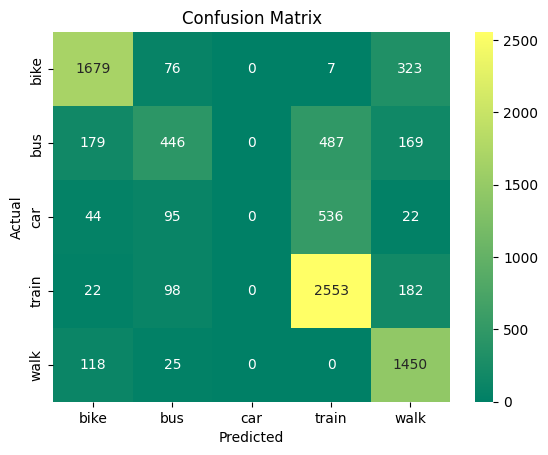

In [ ]:
start_time = time.time()

model = SVC(kernel='rbf', gamma='auto')
model.fit(X_train,y_train)
pred_svm = model.predict(X_test)
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
result_svm=cross_val_score(model,scaled_features,target_feature,cv=10,scoring='accuracy')
print('The overall score for Support Vector machine classifier is:',round(result_svm.mean()*100,2),"\n")

time_in_mins = (time.time() - start_time) / 60
print(f"Total processing time: {time_in_mins:.2f} minutes\n")

y_pred = cross_val_predict(model,scaled_features,target_feature,cv=10)

class_labels = model.classes_
sns.heatmap(confusion_matrix(y_test, pred_svm),
            annot=True,
            cmap='summer',
            fmt='g',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Text(0, 0.5, 'Accuracy')

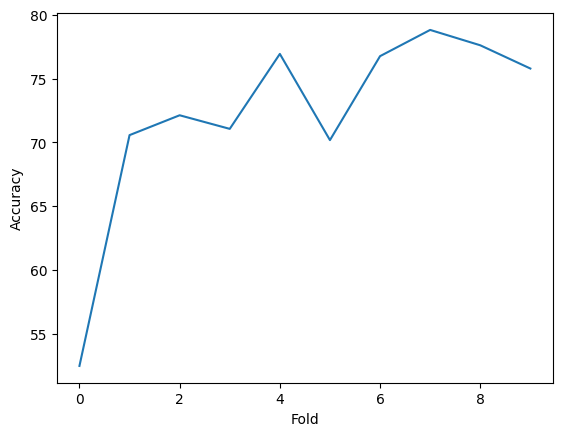

In [ ]:
#SVM fold accuracy visualizer
_result_svm=[r*100 for r in result_svm]
plt.plot(_result_svm)
plt.xlabel('Fold')
plt.ylabel('Accuracy')

### Next Step: ML - Convolutional Neural Network